Large Movie Review Dataset
* 50,000 movie reviews
* 25,000 reviews for training
* 25,000 reviews for testing

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import string
import os
import re

from tensorflow.keras import layers, losses, metrics

In [2]:
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_file = tf.keras.utils.get_file(dataset_url, untar=False, cache_dir='.', cache_subdir='data')
data_path = os.path.join(os.path.dirname(dataset_file), 'aclImdb')

In [3]:
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

In [4]:
remove_dir = os.path.join(train_dir, 'unsup')

if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [7]:
def custom_standardization(input_data):
    text = tf.strings.lower(input_data)
    text = tf.strings.regex_replace(text, '<br />', ' ')
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(string.punctuation), ' ')

    # Remove non-ASCII characters
    text = tf.strings.regex_replace(text, r'[^\x00-\x7F]+', ' ')
     
    return text

In [8]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_sequence_length=sequence_length)

In [9]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [11]:
text_batch, label_batch = next(iter(raw_train_ds))
review, label = text_batch[0], label_batch[0]

print(f'Review:\n{review}')
print(f'\nStandardization:\n{custom_standardization(review)}')
print(f'\nLabel: {label}')
print(f'\nVectorized review:\n{vectorize_text(review, label)}')

Review:
b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a

In [12]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [13]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [14]:
embedding_dim = 16

In [15]:
model = tf.keras.Sequential([
    # vectorize_layer,
    layers.Embedding(vocab_size, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 22s 32ms/step - loss: 0.6654 - accuracy: 0.5069 - val_loss: 0.6200 - val_accuracy: 0.5336
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5513 - accuracy: 0.6416 - val_loss: 0.4997 - val_accuracy: 0.7480
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4411 - accuracy: 0.7920 - val_loss: 0.4165 - val_accuracy: 0.8276
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3706 - accuracy: 0.8462 - val_loss: 0.3659 - val_accuracy: 0.8540
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3247 - accuracy: 0.8716 - val_loss: 0.3346 - val_accuracy: 0.8644
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2927 - accuracy: 0.8850 - val_loss: 0.3138 - val_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2673 - accuracy: 0.8963 - val_loss: 0.3000 - val_accuracy: 0.8754
Ep

In [18]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 32s 41ms/step - loss: 0.2912 - accuracy: 0.8773


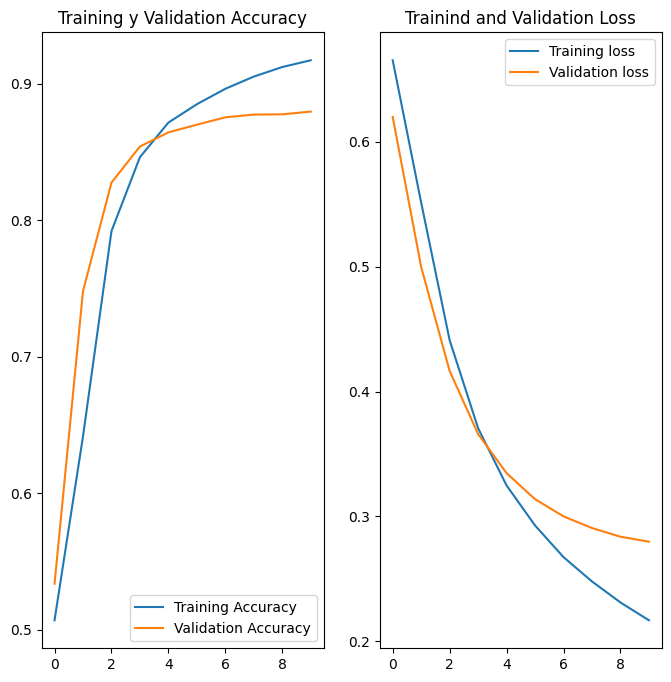

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()

## Export the Model

If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model

In [20]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')])

export_model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)

782/782 [==============================] - 21s 27ms/step - loss: 0.2912 - accuracy: 0.8854


## Inference on new data

In [21]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 323ms/step


array([[0.62833244],
       [0.44703346],
       [0.36528522]], dtype=float32)